In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from time import time
import ipynbname
script_dir = os.getcwd()
filename = ipynbname.name()

import tensorflow as tf
from tensorflow import keras

# our own code
from sde.sde_learning_network_modified import (
    TimingCallback,
    SDEIdentification,
    ModelBuilder,
    SDEApproximationNetwork,
)

from sde.experiment_reports_owen import (
    PlotResults
)

from gillespie.sir import (
    SIRG,
    histogram_data_SIRG,
    plot_histogram_SIRG
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
#  """
# Using the transformed variables
#     xi = arctanh(theta*2-1)
#     theta = tanh(xi)/2+1/2
#     so that we have values from -infty to +infty for xi (theta goes from 0 to 1)
# """


# # def to_theta(xi):
# #     return np.tanh(xi)/2+1/2


# # def from_theta(th):
# #     eps_safe = 1e-16
# #     return np.arctanh(np.clip(th*2-1, -1+eps_safe, 1-eps_safe))


# """
# Do not use transformation.
# """


# def to_theta(xi):
#     return xi


# def from_theta(th):
#     return th

In [5]:
# notebook parameters
n_dimensions = 2
random_seed = 1

# SIR model paramters
k1, k2, k3 = 1, 1, 0
N = 1024

# training data parameters
n_trajectories = 250
n_time_per_trajectory = 4
time_step = 1e-3
n_skip_steps = 10 # how many time steps to skip of the training data, to artificially increase time step


In [41]:
# VAE parameters
n_latent_dimensions = 2
n_layers = 1
n_dim_per_layer = 2**6
LEARNING_RATE = 2e-4

BATCH_SIZE = 128
N_EPOCHS = 100
#ACTIVATIONS = tf.nn.leaky_relu
def ACTIVATIONS(x):
    j = tf.constant(1j, dtype=tf.complex64)
    x = tf.cast(x, dtype=tf.complex64)
    return tf.exp(j * x)
VALIDATION_SPLIT = .1

diffusivity_type = "diagonal"

In [34]:
# approx sde system true drift and diffusion
def true_drift(x):
    theta0 = np.clip(x[:, 0], 0, 1)
    theta2 = np.clip(x[:, 1], 0, 1-theta0)
    theta1 = np.clip(1 - theta0 - theta2, 0, 1)
    r1 = 4*k1*theta0*theta1
    r2 = k2*theta1
    return np.stack([-r1, r2], axis=1)


def true_diffusion(x):
    theta0 = np.clip(x[:, 0], 0, 1)
    theta2 = np.clip(x[:, 1], 0, 1-theta0)
    theta1 = np.clip(1 - theta0 - theta2, 0, 1)
    r1 = 4*k1*theta0*theta1
    r2 = k2*theta1
    epsilon = 1e-8
    return np.transpose(np.array([[np.sqrt(r1/N + epsilon), np.zeros(x.shape[0])], [np.zeros(x.shape[0]), np.sqrt(r2/N + epsilon)]]))


def true_drift_diffusion(x):
    return true_drift(x), true_diffusion(x)


In [35]:
# # create Gillespie training data
# rng = np.random.default_rng(random_state)

# sirg = SIRG(N=N, k1=k1, k2=k2, k3=0)

# x_data = []
# y_data = []
# times = []
# step_sizes = []

# y0_all = []

# for k in range(n_trajectories):
#     # randomly sample the unit cube
#     y0 = rng.uniform(low=0.0, high=1.0, size=(3,))

#     # transform to sample more points on the boundary
#     # y0 = (np.tanh((y0-.5)*5)+1)/2

#     # make sure we only sample admissible initial conditions
#     y0 = np.clip(y0, 0, 1)
#     y0 = y0/np.sum(y0)

#     # only take the first two
#     y0 = y0[:2]

#     y0_all.append(y0)

# y0_all = np.row_stack(y0_all)
# time_g, y = sirg.simulate(y0_all, time_max = n_time_per_trajectory, time_step=time_step)

# for k in range(len(y)):
#     # skip simulated time steps for the training data, so that the individual points are further apart in time
#     time_g[k] = time_g[k][::n_skip_steps]
#     y[k] = y[k][::n_skip_steps,:]

#     if len(time_g[k]) > 2:
#         times.extend(time_g[k][:-1])
#         step_sizes.extend(np.gradient(time_g[k])[:-1])
#         x_data.append(y[k][:-1,:])
#         y_data.append(y[k][1:,:])

# x_data = np.row_stack(x_data)
# y_data = np.row_stack(y_data)
# step_sizes = np.array(step_sizes)
# times = np.array(times)


# def theta02(traj):
#     """
#     Convert theta12 data to theta02 data (theta0 has "more interesting" trajectories)
#     """
#     traj_new = traj.copy()
#     traj_new[:,0] = 1-(traj[:,0]+traj[:,1])
#     return traj_new


# # work with (theta0,theta2) data instead of (theta1,theta2) data (the SDE equations we use to compare later are in terms of theta0,2)
# x_data = theta02(x_data)
# y_data = theta02(y_data)

# print("times", times.shape)
# print("step sizes shape", step_sizes.shape)
# print("x data shape, x0*x1: ", x_data.shape)
# print("y data shape, y0*y1: ", y_data.shape)

# x_data = from_theta(x_data)
# y_data = from_theta(y_data)

In [36]:
# fig,ax=plt.subplots(1,3, figsize=(9,3))
# ax[0].hist(to_theta(x_data)[:,0], 100);
# ax[0].set_ylabel(r"Distribution of $\theta_0$")
# ax[1].hist(to_theta(x_data)[:,1], 100);
# ax[1].set_ylabel(r"Distribution of $\theta_2$")
# ax[2].hist(to_theta(x_data)[:,0]+to_theta(x_data)[:,1]+(1-(to_theta(x_data)[:,0]+to_theta(x_data)[:,1])), 100);
# ax[2].set_ylabel(r"Distribution of $\sum\theta_k$, $k=0,1,2$")
# fig.tight_layout()

# fig.tight_layout()

In [37]:
# # visualize the different step sizes
# fig,ax=plt.subplots(1,1,)
# ax.hist(np.log(step_sizes)/np.log(10), 100);
# ax.set_xlabel("logarithm (base 10) of step size");
# ax.set_ylabel("count");

In [38]:
# # example encoder (Note: the encoder must output the mean and std for a Gaussian)
# use_diag_std = True  # because the true dynamics also is purely diagonal in the noise

# encoder = ModelBuilder.define_gaussian_process(
#                                     n_input_dimensions=n_dimensions,
#                                     n_output_dimensions=n_dimensions,
#                                     n_layers=n_layers,
#                                     n_dim_per_layer=n_dim_per_layer,
#                                     name="GP",
#                                     activation=ACTIVATIONS)#,
#                                     #use_diag_std=use_diag_std)
# model = SDEApproximationNetwork(sde_model=encoder, step_size=None)  # step size will be given during training

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# sde_i = SDEIdentification(model=model)

In [42]:
# train model
No_of_tests = 10
cumulative_times = np.zeros((No_of_tests, N_EPOCHS))
losses = np.zeros((No_of_tests, N_EPOCHS))
val_losses = np.zeros((No_of_tests, N_EPOCHS))
training_time = np.zeros(No_of_tests)
val_loss = np.zeros(No_of_tests)

for i in range(No_of_tests):
    rng = np.random.default_rng(random_seed+i)
    tf.random.set_seed(random_seed+i)

    # generate data
    sirg = SIRG(N=N, k1=k1, k2=k2, k3=0, random_state=(random_seed + i))
    x_data, y_data, step_sizes = sirg.sample_data_SIRG(n_trajectories, n_time_per_trajectory, time_step, n_skip_steps)
    print(x_data.shape)

    # build network
    encoder = ModelBuilder.define_gaussian_process(
                                        n_input_dimensions=n_dimensions,
                                        n_output_dimensions=n_dimensions,
                                        n_layers=n_layers,
                                        n_dim_per_layer=n_dim_per_layer,
                                        name="GP",
                                        activation=ACTIVATIONS,
                                        diffusivity_type=diffusivity_type)
    model = SDEApproximationNetwork(sde_model=encoder, method="euler")
    model.compile(optimizer=tf.keras.optimizers.Adamax(LEARNING_RATE))
    sde_i = SDEIdentification(model=model)
    timing_callback = TimingCallback()

    # train network
    hist, _ = sde_i.train_model(x_data, y_data, step_size=step_sizes, validation_split=VALIDATION_SPLIT, n_epochs=N_EPOCHS, batch_size=BATCH_SIZE, callbacks=[timing_callback])
    
    cumulative_times[i,:] = timing_callback.epoch_times
    losses[i,:] = hist.history["loss"]
    val_losses[i,:] = hist.history["val_loss"]

    moving_avg = np.zeros(N_EPOCHS)
    min_moving_avg = float('inf')
    moving_avg_len = 5
    min_index = 0
    break_iterations = 5
    for j in range(N_EPOCHS):
        if j < moving_avg_len:
            moving_avg[j] = np.mean(val_losses[i,:j+1])
        else:
            moving_avg[j] = np.mean(val_losses[i,j-moving_avg_len+1:j+1])

        if moving_avg[j] < min_moving_avg:
            min_moving_avg = moving_avg[j]
            min_index = j

        if min_index + break_iterations < j:
            break

    val_loss_array = val_losses[i,:j]
    val_loss_min_index = np.argmin(val_loss_array)
    training_time[i] = cumulative_times[i,val_loss_min_index]
    val_loss[i] = val_losses[i,val_loss_min_index]


(22992, 2)
training for 100 epochs with 20692 data points, validating with 2299
(23398, 2)
training for 100 epochs with 21058 data points, validating with 2339
(23161, 2)
training for 100 epochs with 20844 data points, validating with 2316
(22689, 2)
training for 100 epochs with 20420 data points, validating with 2268
(23133, 2)
training for 100 epochs with 20819 data points, validating with 2313
(23548, 2)
training for 100 epochs with 21193 data points, validating with 2354
(22085, 2)
training for 100 epochs with 19876 data points, validating with 2208
(23136, 2)
training for 100 epochs with 20822 data points, validating with 2313
(22528, 2)
training for 100 epochs with 20275 data points, validating with 2252
(22758, 2)
training for 100 epochs with 20482 data points, validating with 2275


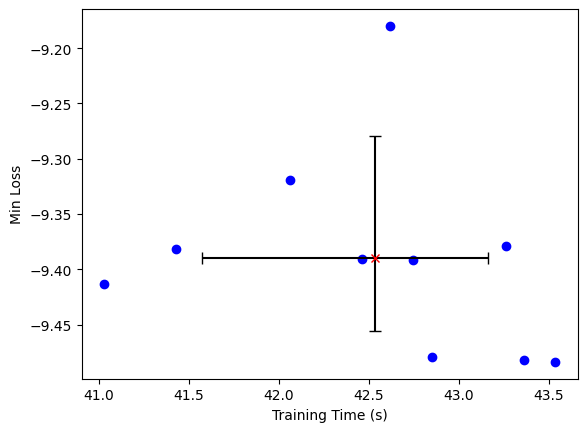

Mean Min Loss:  -9.390179790856404
Mean Training Time:  42.536513924598694


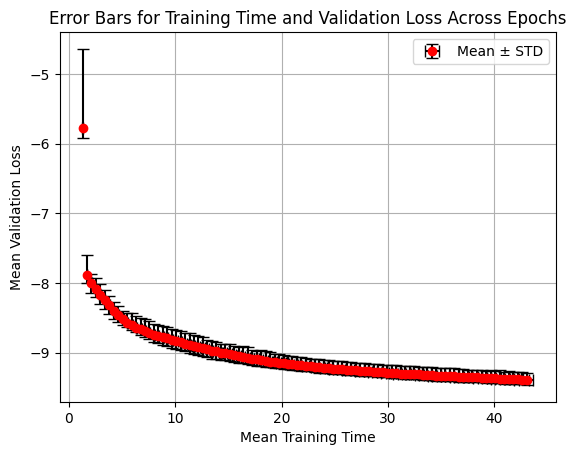

figures_per_row 2


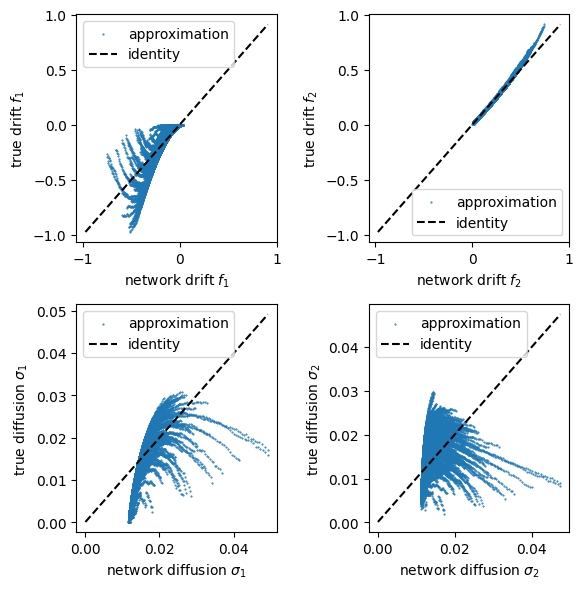

In [43]:
# display and save plots
PR = PlotResults(script_dir=script_dir, filename=filename, n_subsample=n_skip_steps)

if No_of_tests > 1:
    PR.loss_stats(training_time, val_loss, save=True)

PR.loss_v_time(cumulative_times, val_losses, save=True)

PR.plot_results_functions(sde_i.drift_diffusivity, true_drift_diffusion, x_data, save=True)


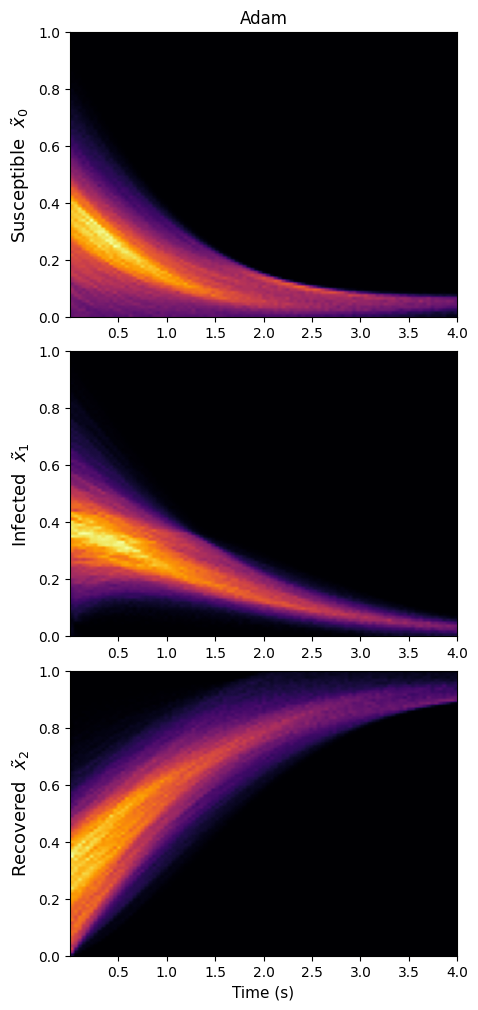

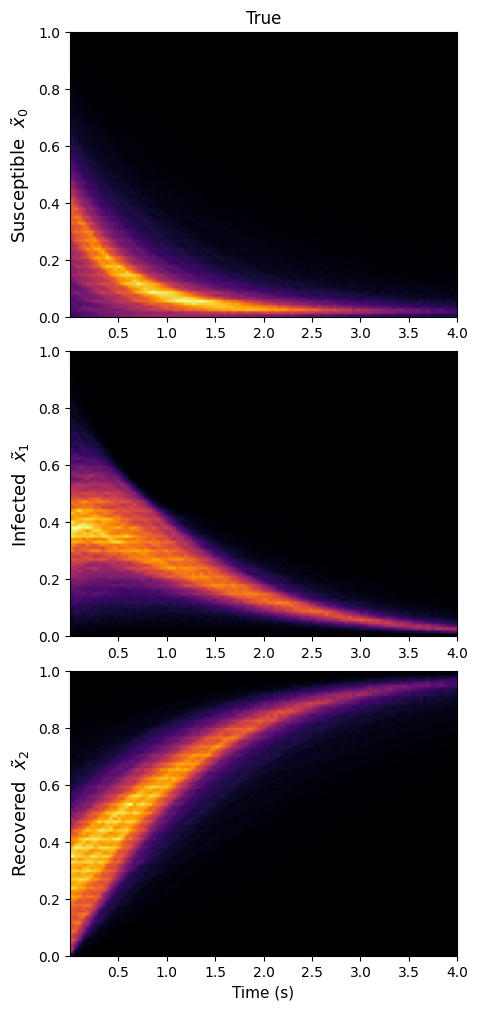

In [44]:
# plot histograms
n_trajectories_hist = 10000
n_time_per_trajectory_hist = 5
time_step_hist = 1e-3
n_skip_steps_hist = 10

y, time_g = sirg.generate_trajectories(n_trajectories_hist, n_time_per_trajectory_hist, time_step_hist, n_skip_steps_hist)
X, time_g_layered = histogram_data_SIRG(sde_i.drift_diffusivity, y, time_g, n_dimensions, rng, ARFF=False)

plot_histogram_SIRG(X, time_g_layered, n_time_per_trajectory, 'Adam', script_dir, filename, n_skip_steps, save=True)
plot_histogram_SIRG(y, time_g, n_time_per_trajectory, 'True', script_dir, filename, n_skip_steps, save=False)

In [10]:
encoder.summary()

Model: "GP_gaussian_process"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 GP_inputs (InputLayer)         [(None, 2)]          0           []                               
                                                                                                  
 GP_mean_hidden_0 (Dense)       (None, 64)           192         ['GP_inputs[0][0]']              
                                                                                                  
 GP_std_hidden_0 (Dense)        (None, 64)           192         ['GP_inputs[0][0]']              
                                                                                                  
 GP_output_mean (Dense)         (None, 2)            130         ['GP_mean_hidden_0[0][0]']       
                                                                                